# KALRNA: Scoring initial poses

## 1. Scoring 3D aligned structures (fragment-based approach)
To evaluate the quality of the alignments produced (see 20190626-KALRNA_genetate_initial_confs), two scores were used to compare the aligned conformations for each follow-up candidate to their respective hit molecule:
- SuCOS score: The SuCOS score is an open-source shape and chemical feature overlap metric
- Tanimoto shape similarity: This score compares the similarity in shape between two molecules

The best conformation for each score is taken as the best initial geometry guess for each candidate molecule.

The results, indicating the best conformation for each candidate molecule for both the 'surprise' and 'similar' sets are returned as a dictionary, which can be displayed and manipulated by pandas. The dictionary gives the best score for each of the two scores described, the conformer-containing sdf file, and the index of the molecule in the sdf file for both scores, so that the conformations can be easily accessed from the original aligned conformer sdf file

### Code (adapted from https://bitbucket.org/Susanhleung/sucos/src/master/calc_SuCOS.py):

In [5]:
import argparse, os, gzip
import glob
import numpy as np
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, rdShapeHelpers
from rdkit.Chem.FeatMaps import FeatMaps
from rdkit import RDConfig
from rdkit.Chem import Draw
from joblib import Parallel, delayed
import multiprocessing
import operator

fdef = AllChem.BuildFeatureFactory(os.path.join(RDConfig.RDDataDir, 'BaseFeatures.fdef'))

fmParams = {}
for k in fdef.GetFeatureFamilies():
    fparams = FeatMaps.FeatMapParams()
    fmParams[k] = fparams

keep = ('Donor', 'Acceptor', 'NegIonizable', 'PosIonizable', 'ZnBinder',
        'Aromatic', 'Hydrophobe', 'LumpedHydrophobe')

def get_FeatureMapScore(small_m, large_m, score_mode=FeatMaps.FeatMapScoreMode.All):
    featLists = []
    for m in [small_m, large_m]:
        rawFeats = fdef.GetFeaturesForMol(m)
        # filter that list down to only include the ones we're intereted in
        featLists.append([f for f in rawFeats if f.GetFamily() in keep])
    fms = [FeatMaps.FeatMap(feats=x, weights=[1] * len(x), params=fmParams) for x in featLists]
    fms[0].scoreMode = score_mode
    fm_score = fms[0].ScoreFeats(featLists[1]) / min(fms[0].GetNumFeatures(), len(featLists[1]))
    return fm_score

def sucos_mol_to_mol(mol1, mol2, score_mode=FeatMaps.FeatMapScoreMode.All):
    ref = Chem.AddHs(mol1)
    prb = Chem.AddHs(mol2)
    
    fm_score = get_FeatureMapScore(ref, prb, score_mode)
    fm_score = np.clip(fm_score, 0, 1)

    protrude_dist = rdShapeHelpers.ShapeProtrudeDist(ref, prb,
            allowReordering=False)
    protrude_dist = np.clip(protrude_dist, 0, 1)

    SuCOS_score = 0.5*fm_score + 0.5*(1 - protrude_dist)
    
    return SuCOS_score


def score(ref_file, prb_file, score_mode=FeatMaps.FeatMapScoreMode.All, p=False):
    reflig = Chem.MolFromMolFile(ref_file, sanitize=True)
    ref = Chem.AddHs(reflig)
    prb_mols = Chem.SDMolSupplier(prb_file, sanitize=True)
    prb_mols = [x for x in prb_mols if x]
    idx = 0
    
    results_sucos = {}
    results_tani = {}
    
    smi_mol = Chem.MolToSmiles(prb_mols[0])
    
    for prb_mol in prb_mols:
        
        prb = Chem.AddHs(prb_mol)
                
        fm_score = get_FeatureMapScore(ref, prb, score_mode)
        fm_score = np.clip(fm_score, 0, 1)
        
        protrude_dist = rdShapeHelpers.ShapeProtrudeDist(ref, prb,
                allowReordering=False)
        protrude_dist = np.clip(protrude_dist, 0, 1)
        
        SuCOS_score = 0.5*fm_score + 0.5*(1 - protrude_dist)
        tanimoto_score = Chem.rdShapeHelpers.ShapeTanimotoDist(ref, prb)
        
        results_sucos[str(idx)] = SuCOS_score
        results_tani[str(idx)] = tanimoto_score
        
        if p:
        
            print ("********************************")
            print ("index: " + str(idx))
            print ("SuCOS score:\t%f" % SuCOS_score)
            print ("Tani score:\t%f" % tanimoto_score)
            print ("********************************")
        
        idx+=1

    return results_sucos, results_tani, smi_mol, prb_mols, reflig


def select_highest(results, number):
    ids = []
    r = results
    while len(ids)<number:
        i = max(results.items(), key=operator.itemgetter(1))[0]
        ids.append(int(i))
        r.pop(i, None)
    return ids

def select_lowest(results, number):
    ids = []
    r = results
    while len(ids)<number:
        i = min(results.items(), key=operator.itemgetter(1))[0]
        ids.append(int(i))
        r.pop(i, None)
    return ids

def score_all_confs(hit_file_directory, initial_hit, all_confs_paths):

    all_results_dict = {
        'candidate_name': [],
        'candidate_smiles': [],
        'candidate_conformers_file': [],
        'initial_hit': [],
        'best_sucos': [],
        'best_sucos_id': [],
        'best_tanimoto': [],
        'best_tanimoto_id': [],
    }
    
    for i in range(0, len(all_confs_paths)):
        results_sucos, results_tani, smiles, prb_mols, reflig = score(ref_file=initial_hit, prb_file=all_confs_paths[i])
        print('running ' + str(i) + '/' + str(len(all_confs_paths)))
        # best sucos socre and id
        r = results_sucos.copy()
        idx = select_highest(r, 1)[0]
        sucos_score = results_sucos[str(idx)]
        # best tanimoto socre and id
        s = results_tani.copy()
        idy = select_lowest(s, 1)[0]
        tani_score = results_tani[str(idy)]

        all_results_dict['candidate_name'].append(all_confs_paths[i].split('/')[-1].replace('_confs_aligned.sdf', ''))
        all_results_dict['candidate_smiles'].append(smiles)
        all_results_dict['candidate_conformers_file'].append(all_confs_paths[i])
        all_results_dict['initial_hit'].append(initial_hit.split('/')[-1])
        all_results_dict['best_sucos'].append(sucos_score)
        all_results_dict['best_sucos_id'].append(idx)
        all_results_dict['best_tanimoto'].append(tani_score)
        all_results_dict['best_tanimoto_id'].append(idy)

    return all_results_dict

In [6]:
hit_file_directory = '/data/XX02KALRNA-x1389_1/'
initial_hit = '/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1.sdf'
all_confs_paths = glob.glob(str(hit_file_directory + '*_confs_aligned.sdf'))

all_results_dict = score_all_confs(hit_file_directory=hit_file_directory, 
                                   initial_hit=initial_hit, 
                                   all_confs_paths=all_confs_paths)

running 0/1999
running 1/1999
running 2/1999
running 3/1999
running 4/1999
running 5/1999
running 6/1999
running 7/1999
running 8/1999
running 9/1999
running 10/1999
running 11/1999
running 12/1999
running 13/1999
running 14/1999
running 15/1999
running 16/1999
running 17/1999
running 18/1999
running 19/1999
running 20/1999
running 21/1999
running 22/1999
running 23/1999
running 24/1999
running 25/1999
running 26/1999
running 27/1999
running 28/1999
running 29/1999
running 30/1999
running 31/1999
running 32/1999
running 33/1999
running 34/1999
running 35/1999
running 36/1999
running 37/1999
running 38/1999
running 39/1999
running 40/1999
running 41/1999
running 42/1999
running 43/1999
running 44/1999
running 45/1999
running 46/1999
running 47/1999
running 48/1999
running 49/1999
running 50/1999
running 51/1999
running 52/1999
running 53/1999
running 54/1999
running 55/1999
running 56/1999
running 57/1999
running 58/1999
running 59/1999
running 60/1999
running 61/1999
running 62/1999
ru

running 489/1999
running 490/1999
running 491/1999
running 492/1999
running 493/1999
running 494/1999
running 495/1999
running 496/1999
running 497/1999
running 498/1999
running 499/1999
running 500/1999
running 501/1999
running 502/1999
running 503/1999
running 504/1999
running 505/1999
running 506/1999
running 507/1999
running 508/1999
running 509/1999
running 510/1999
running 511/1999
running 512/1999
running 513/1999
running 514/1999
running 515/1999
running 516/1999
running 517/1999
running 518/1999
running 519/1999
running 520/1999
running 521/1999
running 522/1999
running 523/1999
running 524/1999
running 525/1999
running 526/1999
running 527/1999
running 528/1999
running 529/1999
running 530/1999
running 531/1999
running 532/1999
running 533/1999
running 534/1999
running 535/1999
running 536/1999
running 537/1999
running 538/1999
running 539/1999
running 540/1999
running 541/1999
running 542/1999
running 543/1999
running 544/1999
running 545/1999
running 546/1999
running 547/19

running 971/1999
running 972/1999
running 973/1999
running 974/1999
running 975/1999
running 976/1999
running 977/1999
running 978/1999
running 979/1999
running 980/1999
running 981/1999
running 982/1999
running 983/1999
running 984/1999
running 985/1999
running 986/1999
running 987/1999
running 988/1999
running 989/1999
running 990/1999
running 991/1999
running 992/1999
running 993/1999
running 994/1999
running 995/1999
running 996/1999
running 997/1999
running 998/1999
running 999/1999
running 1000/1999
running 1001/1999
running 1002/1999
running 1003/1999
running 1004/1999
running 1005/1999
running 1006/1999
running 1007/1999
running 1008/1999
running 1009/1999
running 1010/1999
running 1011/1999
running 1012/1999
running 1013/1999
running 1014/1999
running 1015/1999
running 1016/1999
running 1017/1999
running 1018/1999
running 1019/1999
running 1020/1999
running 1021/1999
running 1022/1999
running 1023/1999
running 1024/1999
running 1025/1999
running 1026/1999
running 1027/1999
run

running 1428/1999
running 1429/1999
running 1430/1999
running 1431/1999
running 1432/1999
running 1433/1999
running 1434/1999
running 1435/1999
running 1436/1999
running 1437/1999
running 1438/1999
running 1439/1999
running 1440/1999
running 1441/1999
running 1442/1999
running 1443/1999
running 1444/1999
running 1445/1999
running 1446/1999
running 1447/1999
running 1448/1999
running 1449/1999
running 1450/1999
running 1451/1999
running 1452/1999
running 1453/1999
running 1454/1999
running 1455/1999
running 1456/1999
running 1457/1999
running 1458/1999
running 1459/1999
running 1460/1999
running 1461/1999
running 1462/1999
running 1463/1999
running 1464/1999
running 1465/1999
running 1466/1999
running 1467/1999
running 1468/1999
running 1469/1999
running 1470/1999
running 1471/1999
running 1472/1999
running 1473/1999
running 1474/1999
running 1475/1999
running 1476/1999
running 1477/1999
running 1478/1999
running 1479/1999
running 1480/1999
running 1481/1999
running 1482/1999
running 14

running 1884/1999
running 1885/1999
running 1886/1999
running 1887/1999
running 1888/1999
running 1889/1999
running 1890/1999
running 1891/1999
running 1892/1999
running 1893/1999
running 1894/1999
running 1895/1999
running 1896/1999
running 1897/1999
running 1898/1999
running 1899/1999
running 1900/1999
running 1901/1999
running 1902/1999
running 1903/1999
running 1904/1999
running 1905/1999
running 1906/1999
running 1907/1999
running 1908/1999
running 1909/1999
running 1910/1999
running 1911/1999
running 1912/1999
running 1913/1999
running 1914/1999
running 1915/1999
running 1916/1999
running 1917/1999
running 1918/1999
running 1919/1999
running 1920/1999
running 1921/1999
running 1922/1999
running 1923/1999
running 1924/1999
running 1925/1999
running 1926/1999
running 1927/1999
running 1928/1999
running 1929/1999
running 1930/1999
running 1931/1999
running 1932/1999
running 1933/1999
running 1934/1999
running 1935/1999
running 1936/1999
running 1937/1999
running 1938/1999
running 19

### 1.1 Evaluating the scores of aligned conformers

The results dictionary from above can be displayed by pandas. Showing the resulting data, sorted on 'best_sucos' shows that (according to sucos) the molecules we have generated are very similar, in shape and feature, to the starting hit molecule.

We can also see that the majority of the top ranked compounds are from the 'similar' set - which is to be expected. To add some diversity to the molecules that will be investigated further, the two sets have been separated back out for analysis (and the results saved out as csv files so we can look again later).

In [7]:
import pandas as pd
# create dataframe from results of scoring alignments
df = pd.DataFrame.from_dict(all_results_dict)

# top 500 compounds from each search set(similar/surprise) and score(sucos/tanimoto)
best_sucos_similar = df[df['candidate_name'].str.contains("similar")].sort_values(by=['best_sucos'], ascending=False).head(500)
best_tanimoto_similar = df[df['candidate_name'].str.contains("similar")].sort_values(by=['best_tanimoto'], ascending=True).head(500)
best_sucos_surprise = df[df['candidate_name'].str.contains("surprise")].sort_values(by=['best_sucos'], ascending=False).head(500)
best_tanimoto_surprise = df[df['candidate_name'].str.contains("surprise")].sort_values(by=['best_tanimoto'], ascending=True).head(500)

# save the top 500 as csv files
best_sucos_similar.to_csv('/data/XX02KALRNA-x1389_1/500_similar_sucos.csv')
best_tanimoto_similar.to_csv('/data/XX02KALRNA-x1389_1/500_similar_tanimoto.csv')
best_sucos_surprise.to_csv('/data/XX02KALRNA-x1389_1/500_surprise_sucos.csv')
best_tanimoto_surprise.to_csv('/data/XX02KALRNA-x1389_1/500_surprise_tanimoto.csv')

# display results frame
df.sort_values(by=['best_sucos'], ascending=False)

,candidate_name,candidate_smiles,candidate_conformers_file,initial_hit,best_sucos,best_sucos_id,best_tanimoto,best_tanimoto_id
837,XX02KALRNA-x1389_1-similar-rsn_167,CC1(NC(=O)Nc2nccs2)CC1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.950366,37,0.235174,90
388,XX02KALRNA-x1389_1-similar-rsn_650,O=C(Nc1nccs1)NC1CC1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.941898,31,0.185700,90
1867,XX02KALRNA-x1389_1-similar-rsn_491,O=C(NCC(F)F)Nc1nccs1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.941776,52,0.223690,92
598,XX02KALRNA-x1389_1-similar-rsn_467,CCCNC(=O)Nc1cc(C)cc(C)n1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.940154,84,0.352607,25
243,XX02KALRNA-x1389_1-similar-rsn_779,C#CCCNC(=O)Nc1cc(C)cc(C)n1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.937156,35,0.387637,28
310,XX02KALRNA-x1389_1-similar-rsn_986,CC#CCNC(=O)Nc1nccs1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.936107,8,0.266176,8
191,XX02KALRNA-x1389_1-similar-rsn_406,C=C(C)CNC(=O)Nc1nccs1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.933494,91,0.268867,69
1856,XX02KALRNA-x1389_1-similar-rsn_915,CC(C)CNC(=O)Nc1nccs1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.932710,32,0.255188,6
923,XX02KALRNA-x1389_1-similar-rsn_383,Cc1cnc(NC(=O)NCC(Cl)Cl)s1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.931955,24,0.332008,97
1454,XX02KALRNA-x1389_1-similar-rsn_643,C#CC(C)NC(=O)Nc1cccc(C)n1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.931741,27,0.322749,26


### 1.2 Evaluating the diversity of the top-scoring candidates

Given the SuCos scores (and tanimoto scores) of the highest-scored compounds are extremely similar to each other (e.g. the top 14 compounds all have a SuCOS score of 0.98), it is likely that the compounds themselves are very similar to each other, and do not represent a chemically-diverse set.

To evaluate this, the sucos score for each of the top 500 compounds (scored with sucos) with every other compound  for both the similar and surprise sets was calculated

In [25]:
from rdkit.Chem.rdMolDescriptors import GetMorganFingerprint
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker

def mols_from_df(df, files_col='candidate_conformers_file', id_col='best_sucos_id'):
    mols = [Chem.SDMolSupplier(f)[int(idx)] for f, idx in [(df.iloc[i][files_col], 
                                                            df.iloc[i][id_col]) 
                                                           for i in range(0, len(df))]]
    return mols

def mols_from_morgan(mols, number):
    
    fps = [GetMorganFingerprint(x,3) for x in mols]
    
    def distij(i,j,fps=fps):
        return 1-DataStructs.DiceSimilarity(fps[i],fps[j])
    
    nfps = len(fps)
    picker = MaxMinPicker()
    pickIndices = picker.LazyPick(distij,nfps,number,seed=23)
    picks = [mols[x] for x in pickIndices]
    
    return picks, pickIndices






def compare_mols_sucos(df):
    mat = []
    i = 0
    for mol1 in df:
        print('eval mol ' + str(i))
        arr = []
        for mol2 in df:
            arr.append(sucos_mol_to_mol(mol1=mol1, mol2=mol2))
        mat.append(arr)
        i += 1
    return mat

In [10]:
top_500_similar_mols = mols_from_df(best_sucos_similar)
top_500_similar_mat = compare_mols_sucos(top_500_similar_mols)

eval mol 0
eval mol 1
eval mol 2
eval mol 3
eval mol 4
eval mol 5
eval mol 6
eval mol 7
eval mol 8
eval mol 9
eval mol 10
eval mol 11
eval mol 12
eval mol 13
eval mol 14
eval mol 15
eval mol 16
eval mol 17
eval mol 18
eval mol 19
eval mol 20
eval mol 21
eval mol 22
eval mol 23
eval mol 24
eval mol 25
eval mol 26
eval mol 27
eval mol 28
eval mol 29
eval mol 30
eval mol 31
eval mol 32
eval mol 33
eval mol 34
eval mol 35
eval mol 36
eval mol 37
eval mol 38
eval mol 39
eval mol 40
eval mol 41
eval mol 42
eval mol 43
eval mol 44
eval mol 45
eval mol 46
eval mol 47
eval mol 48
eval mol 49
eval mol 50
eval mol 51
eval mol 52
eval mol 53
eval mol 54
eval mol 55
eval mol 56
eval mol 57
eval mol 58
eval mol 59
eval mol 60
eval mol 61
eval mol 62
eval mol 63
eval mol 64
eval mol 65
eval mol 66
eval mol 67
eval mol 68
eval mol 69
eval mol 70
eval mol 71
eval mol 72
eval mol 73
eval mol 74
eval mol 75
eval mol 76
eval mol 77
eval mol 78
eval mol 79
eval mol 80
eval mol 81
eval mol 82
eval mol 83
ev

In [12]:
top_500_surprise_mols = mols_from_df(best_sucos_surprise)
top_500_surprise_mat = compare_mols_sucos(top_500_surprise_mols)

eval mol 0
eval mol 1
eval mol 2
eval mol 3
eval mol 4
eval mol 5
eval mol 6
eval mol 7
eval mol 8
eval mol 9
eval mol 10
eval mol 11
eval mol 12
eval mol 13
eval mol 14
eval mol 15
eval mol 16
eval mol 17
eval mol 18
eval mol 19
eval mol 20
eval mol 21
eval mol 22
eval mol 23
eval mol 24
eval mol 25
eval mol 26
eval mol 27
eval mol 28
eval mol 29
eval mol 30
eval mol 31
eval mol 32
eval mol 33
eval mol 34
eval mol 35
eval mol 36
eval mol 37
eval mol 38
eval mol 39
eval mol 40
eval mol 41
eval mol 42
eval mol 43
eval mol 44
eval mol 45
eval mol 46
eval mol 47
eval mol 48
eval mol 49
eval mol 50
eval mol 51
eval mol 52
eval mol 53
eval mol 54
eval mol 55
eval mol 56
eval mol 57
eval mol 58
eval mol 59
eval mol 60
eval mol 61
eval mol 62
eval mol 63
eval mol 64
eval mol 65
eval mol 66
eval mol 67
eval mol 68
eval mol 69
eval mol 70
eval mol 71
eval mol 72
eval mol 73
eval mol 74
eval mol 75
eval mol 76
eval mol 77
eval mol 78
eval mol 79
eval mol 80
eval mol 81
eval mol 82
eval mol 83
ev

In [283]:
top_500_similar_mat=mat

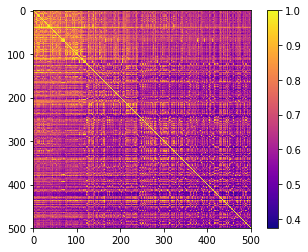

In [11]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
m = np.array(top_500_similar_mat)
plt.imshow(m, interpolation='nearest', cmap='plasma')
plt.colorbar()
plt.show()

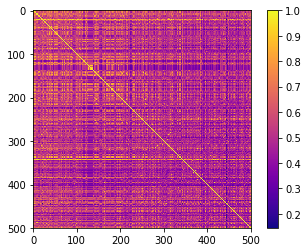

In [13]:
m = np.array(top_500_surprise_mat)
plt.imshow(m, interpolation='nearest', cmap='plasma')
plt.colorbar()
plt.show()

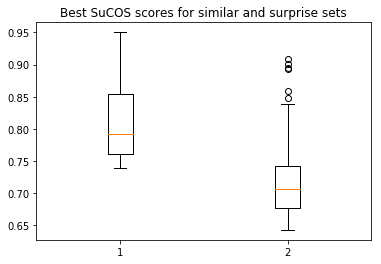

In [14]:
fig7, ax7 = plt.subplots()
ax7.set_title('Best SuCOS scores for similar and surprise sets')
ax7.boxplot([list(best_sucos_similar['best_sucos']), list(best_sucos_surprise['best_sucos'])])

plt.show()

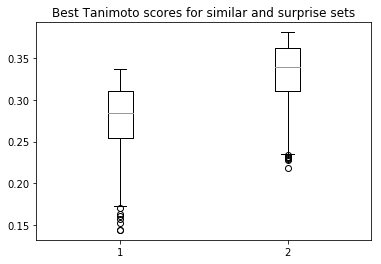

In [15]:
fig7, ax7 = plt.subplots()
ax7.set_title('Best Tanimoto scores for similar and surprise sets')
ax7.boxplot([list(best_tanimoto_similar['best_tanimoto']), list(best_tanimoto_surprise['best_tanimoto'])])

plt.show()

In [27]:
top_250_similar_diverse, inds_250sd = mols_from_morgan(top_500_similar_mols, 250)  
df250 = best_sucos_similar.iloc[inds_250sd]

In [29]:
df250.sort_values(by=['best_sucos'], ascending=False)

,candidate_name,candidate_smiles,candidate_conformers_file,initial_hit,best_sucos,best_sucos_id,best_tanimoto,best_tanimoto_id
837,XX02KALRNA-x1389_1-similar-rsn_167,CC1(NC(=O)Nc2nccs2)CC1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.950366,37,0.235174,90
388,XX02KALRNA-x1389_1-similar-rsn_650,O=C(Nc1nccs1)NC1CC1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.941898,31,0.185700,90
1867,XX02KALRNA-x1389_1-similar-rsn_491,O=C(NCC(F)F)Nc1nccs1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.941776,52,0.223690,92
243,XX02KALRNA-x1389_1-similar-rsn_779,C#CCCNC(=O)Nc1cc(C)cc(C)n1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.937156,35,0.387637,28
310,XX02KALRNA-x1389_1-similar-rsn_986,CC#CCNC(=O)Nc1nccs1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.936107,8,0.266176,8
1454,XX02KALRNA-x1389_1-similar-rsn_643,C#CC(C)NC(=O)Nc1cccc(C)n1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.931741,27,0.322749,26
524,XX02KALRNA-x1389_1-similar-rsn_435,Cc1cc(C)nc(NC(=O)NC(C)C)c1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.929005,0,0.329351,89
1530,XX02KALRNA-x1389_1-similar-rsn_723,C#CCCNC(=O)Nc1nc(C)cs1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.928673,92,0.313042,92
1648,XX02KALRNA-x1389_1-similar-rsn_674,CCCNC(=O)Nc1cc(C)c(C)cn1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.928241,99,0.345393,73
29,XX02KALRNA-x1389_1-similar-rsn_760,CC#CCNC(=O)Nc1ncc(C)s1,/data/XX02KALRNA-x1389_1/XX02KALRNA-x1389_1-si...,XX02KALRNA-x1389_1.sdf,0.927031,70,0.335566,70


In [30]:
df = df250.sort_values(by=['best_sucos'], ascending=False)

df250_mols = mols_from_df(df)
top_250_similar_diverse_mat = compare_mols_sucos(df250_mols)

eval mol 0
eval mol 1
eval mol 2
eval mol 3
eval mol 4
eval mol 5
eval mol 6
eval mol 7
eval mol 8
eval mol 9
eval mol 10
eval mol 11
eval mol 12
eval mol 13
eval mol 14
eval mol 15
eval mol 16
eval mol 17
eval mol 18
eval mol 19
eval mol 20
eval mol 21
eval mol 22
eval mol 23
eval mol 24
eval mol 25
eval mol 26
eval mol 27
eval mol 28
eval mol 29
eval mol 30
eval mol 31
eval mol 32
eval mol 33
eval mol 34
eval mol 35
eval mol 36
eval mol 37
eval mol 38
eval mol 39
eval mol 40
eval mol 41
eval mol 42
eval mol 43
eval mol 44
eval mol 45
eval mol 46
eval mol 47
eval mol 48
eval mol 49
eval mol 50
eval mol 51
eval mol 52
eval mol 53
eval mol 54
eval mol 55
eval mol 56
eval mol 57
eval mol 58
eval mol 59
eval mol 60
eval mol 61
eval mol 62
eval mol 63
eval mol 64
eval mol 65
eval mol 66
eval mol 67
eval mol 68
eval mol 69
eval mol 70
eval mol 71
eval mol 72
eval mol 73
eval mol 74
eval mol 75
eval mol 76
eval mol 77
eval mol 78
eval mol 79
eval mol 80
eval mol 81
eval mol 82
eval mol 83
ev

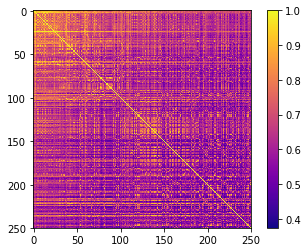

In [31]:
m = np.array(top_250_similar_diverse_mat)
plt.imshow(m, interpolation='nearest', cmap='plasma')
plt.colorbar()
plt.show()

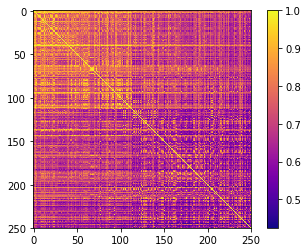

In [32]:
nl = []
for l in top_500_similar_mat[:250]:
    nl.append(l[:250])
m = np.array(nl)
plt.imshow(m, interpolation='nearest', cmap='plasma')
plt.colorbar()
plt.show()

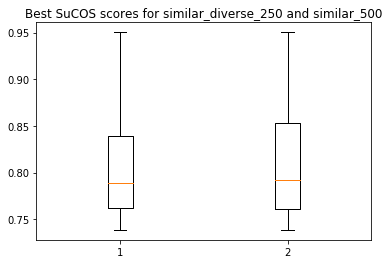

In [33]:
fig7, ax7 = plt.subplots()
ax7.set_title('Best SuCOS scores for similar_diverse_250 and similar_500')
ax7.boxplot([list(df['best_sucos']), list(best_sucos_similar['best_sucos'])])

plt.show()

In [34]:
best_sucos_surprise.iloc[:250].to_csv('/data/XX02KALRNA-x1389_1/250_surprise_sucos.csv')

In [35]:
df.to_csv('/data/XX02KALRNA-x1389_1/250_similar_sucos_diverse.csv')

In [36]:
writer = Chem.SDWriter('/data/XX02KALRNA-x1389_1/250_similar_sucos_diverse.sdf')
for mol in df250_mols:
    writer.write(mol)

In [37]:
writer = Chem.SDWriter('/data/XX02KALRNA-x1389_1/250_surprise_sucos.sdf')
for mol in top_500_surprise_mols[:250]:
    writer.write(mol)